In this notebook, we'll be using runge kutta to numerically integrate a system of ODEs. This will not involved PINNS, but is an important precurser to more intersting prohblems

The first problem we will solve will be the lorenz attrator:
    
    
$$
x_t =\sigma (y-z)
$$

$$
y_t =x(\rho - z) -y 
$$

$$
z_t = x y - \beta z
$$

In [15]:
from scipy import integrate as inte
import numpy as np
import matplotlib.pyplot as plt

In [16]:
sigma = 10.0
rho = 28.0
beta = 8/3

In [17]:
def lorenz(t,x):
    return np.array([sigma*(x[1] - x[0]),
                     x[0]*(rho - x[2]) - x[1],
                     x[0]*x[1] - beta*x[2]])

In [18]:
u0 = np.array([1,0,0])
# Definet the solution
solution = inte.RK45(lorenz, 0 , u0 , 100, rtol = 1e-6)

In [19]:
# collect data
t_values = []
y_values = []
while solution.status == "running":
    # get solution step state
    solution.step()
    t_values.append(solution.t)
    y_values.append(solution.y)

In [20]:
y_values =np.vstack(y_values)

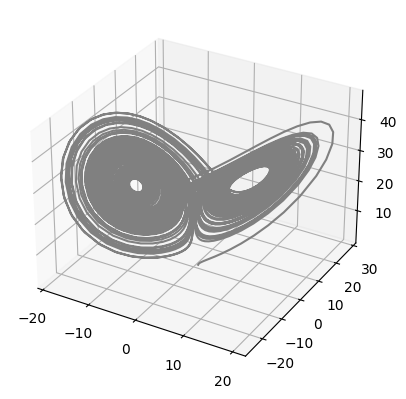

In [21]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(y_values[:,0], y_values[:,1], y_values[:,2], 'gray')

In [22]:
solution.status

'finished'

This is great. But now we want to solve systems of equations where the parameters themselves are time varying. 

Suppose we have a pendulum which has a certain level of friction. This friction starts off being high and then suddenly reduces. How would we solve this?

The equations are:
    
$$
\theta'' = -g/Lsin(\theta) - \lambda \theta'
$$

In [23]:
G = 9.8
lam = 0

In [24]:
def pendulum(t,x):
    return np.array([x[1],
                     -G*np.sin(x[0]) - lam*x[1] ])

In [25]:
u0 = np.array([np.pi/2,0])
# Definet the solution
solution = inte.RK45(pendulum, 0 , u0 , 20, rtol = 1e-6)

In [26]:
# collect data
t_values = []
y_values = []
while solution.status == "running":
    # get solution step state
    solution.step()
    t_values.append(solution.t)
    y_values.append(solution.y)
y_values =np.vstack(y_values)

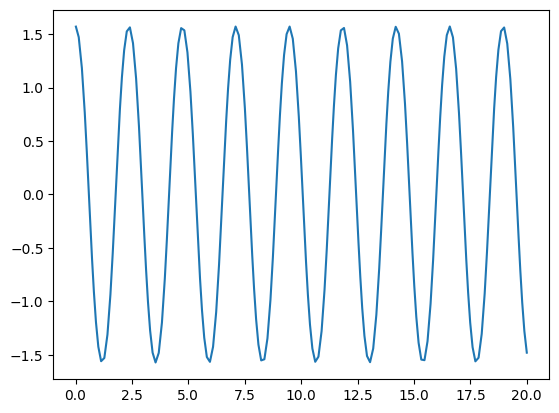

In [27]:
fig = plt.figure()
plt.plot(t_values, y_values[:,0])

Now let's say that when t = 10, we change the friction suddenly

In [28]:
G = 9.8
lam = 0
def pendulum(t,x):
    return np.array([x[1],
                     -G*np.sin(x[0]) - lam*x[1] ])

In [29]:
u0 = np.array([np.pi/2,0])
solution = inte.RK45(pendulum, 0 , u0 , 20, rtol = 1e-6)

# collect data
t_values = []
y_values = []
lam_values = []
while solution.status == "running":
    
    # get solution step state
    solution.step()
    t_values.append(solution.t)
    y_values.append(solution.y)
    lam_values.append(lam)
    
    if solution.t>10:
        lam = 0.5

y_values =np.vstack(y_values)

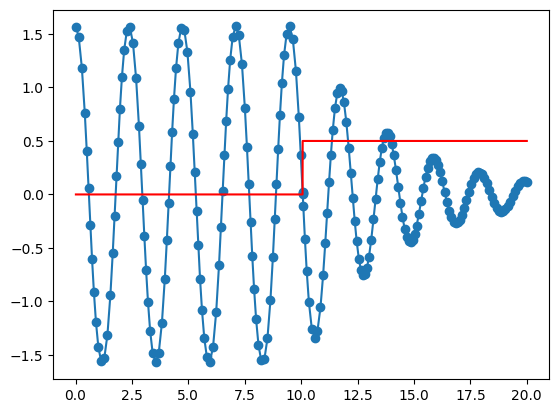

In [30]:
fig = plt.figure()
plt.plot(t_values, y_values[:,0],'o-')
plt.plot(t_values, lam_values,'r-')

Now let's see what happens when I make lambda change randomly

In [31]:
G = 9.8
lam = 0
def pendulum(t,x):
    return np.array([x[1],
                     -G*np.sin(x[0]) - lam*x[1] ])

u0 = np.array([np.pi/2,0])
solution = inte.RK45(pendulum, 0 , u0 , 20, rtol = 1e-6)

# Make Lambda to be a random function that changs every second
lam_vector = np.random.uniform(0,0.5,size = 20)

# collect data
t_values = []
y_values = []
lam_values = []
while solution.status == "running":
    lam = lam_vector[int(np.floor(solution.t))]
    
    # get solution step state
    solution.step()
    t_values.append(solution.t)
    y_values.append(solution.y)
    lam_values.append(lam)
    

y_values =np.vstack(y_values)

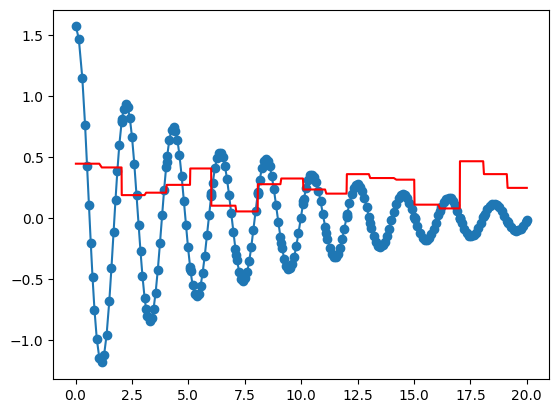

In [32]:
fig = plt.figure()
plt.plot(t_values, y_values[:,0],'o-')
plt.plot(t_values, lam_values,'r-')

Another strategy that might be better is to have lambda as a function and and pass it in directly. We can do this through interpolation

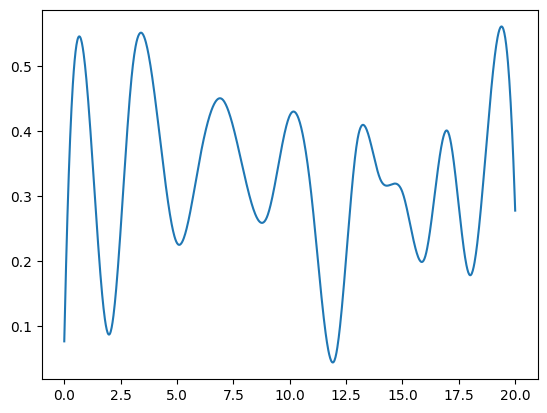

In [33]:
from scipy.interpolate import interp1d
t = np.linspace(0,20,21)
lam_vector = np.random.uniform(0,0.5,size = 21)
lam = interp1d(t, lam_vector, kind='cubic')
t_new =  np.linspace(0,20,1000)
plt.plot(t_new,lam(t_new))
    

In [34]:
G = 9.8
def pendulum(t,x):
    return np.array([x[1],-G*np.sin(x[0]) - lam(t)*x[1] ])

In [35]:
u0 = np.array([np.pi/2,0])
solution = inte.RK45(pendulum, 0 , u0 , 20, rtol = 1e-6)

# collect data
t_values = []
y_values = []
lam_values = []
while solution.status == "running":
    
    # get solution step state
    solution.step()
    t_values.append(solution.t)
    y_values.append(solution.y)
    lam_values.append(lam(solution.t))
    

y_values =np.vstack(y_values)

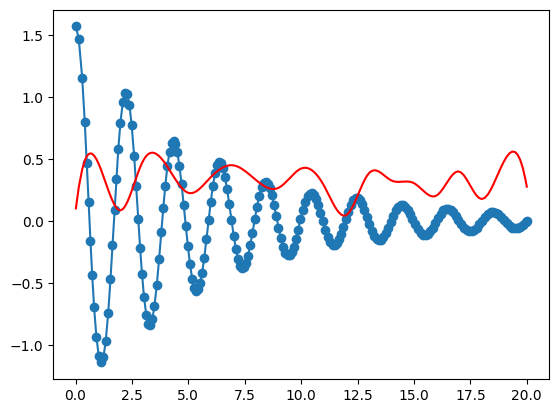

In [36]:
fig = plt.figure()
plt.plot(t_values, y_values[:,0],'o-')
plt.plot(t_values, lam_values,'r-')

In general we want to know if doing it outside or inside is more accurate?

Create a step function lam

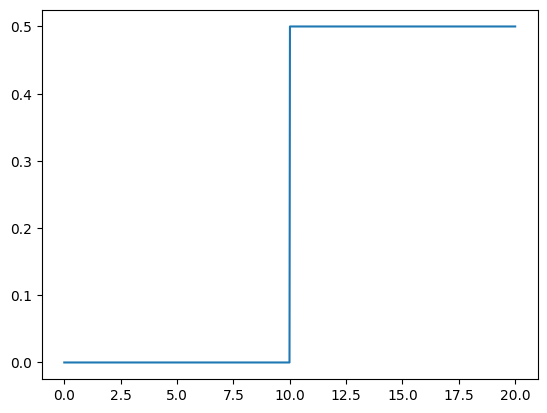

In [37]:
def lam_func(t,data):
    return data[int(np.floor(t))]

lam_vector =np.array([0,0,0,0,0,0,0,0,0,0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5])
t_new =  np.linspace(0,20,1000)
lam_sim = [lam_func(t,lam_vector) for t in t_new]
plt.plot(t_new,lam_sim)  

In [38]:
G = 9.8
lam_const = 0.1
def pendulum1(t,x):
    return np.array([x[1],-G*np.sin(x[0]) - lam_func(t,lam_vector)*x[1] ])

def pendulum2(t,x):
    return np.array([x[1],-G*np.sin(x[0]) - lam_const*x[1] ])

u0 = np.array([np.pi/2,0])
solution1 = inte.RK45(pendulum1, 0 , u0 , 20, rtol = 1e-6)
solution2 = inte.RK45(pendulum2, 0 , u0 , 20, rtol = 1e-6)

# collect data
t_values1 = []
y_values1 = []
lam_values1 = []
while solution1.status == "running":
    lam_values1.append(lam_func(solution1.t,lam_vector))
    # get solution step state
    solution1.step()
    t_values1.append(solution1.t)
    y_values1.append(solution1.y)

y_values1 =np.vstack(y_values1)


# collect data
t_values2 = []
y_values2 = []
lam_values2 = []
while solution2.status == "running":
    
    lam_const = lam_func(solution2.t,lam_vector)
    
    # get solution step state
    solution2.step()
    t_values2.append(solution2.t)
    y_values2.append(solution2.y)
    lam_values2.append(lam_const)
    

y_values2 =np.vstack(y_values2)


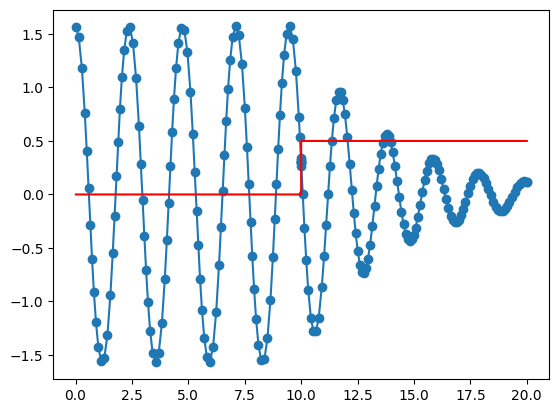

In [39]:
fig = plt.figure()
plt.plot(t_values1, y_values1[:,0],'o-')
plt.plot(t_values1, lam_values1,'r-')

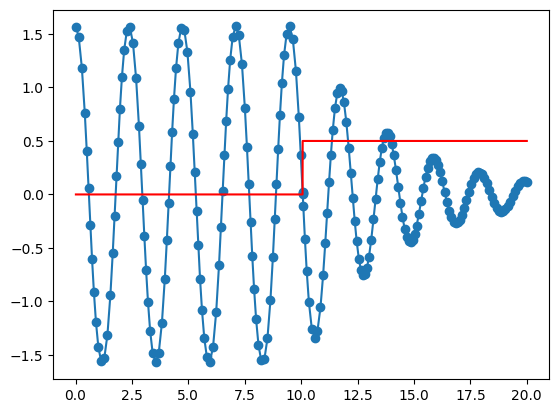

In [40]:
fig = plt.figure()
plt.plot(t_values2, y_values2[:,0],'o-')
plt.plot(t_values2, lam_values2,'r-')

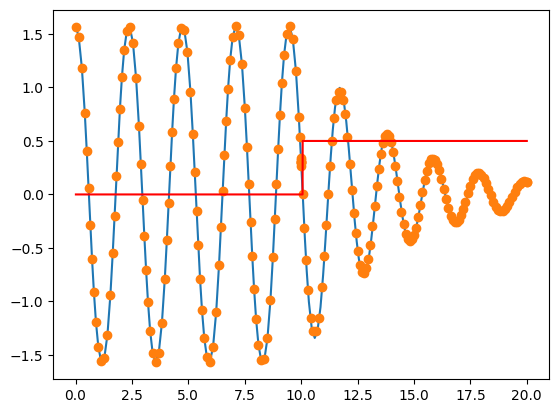

In [41]:
fig = plt.figure()
plt.plot(t_values2, y_values2[:,0],'-')
plt.plot(t_values1, y_values1[:,0],'o')
plt.plot(t_values2, lam_values2,'r-')

Another to run the simulation is to use Do-mpc. Do-mpc only allows you to control linear dynamic systems in closed loop

# Do MPC

Our problem will be an inverted pendulum where we can apply a torque to the pivot point. The equatoins ofmotion are:

$$
\theta'' = g/l \sin(\theta) + \tau
$$

Where theta is measured from the top

In [223]:
import do_mpc
from casadi import *

In [224]:
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

phi = model.set_variable(var_type='_x', var_name='phi', shape=(2,1))
tau = model.set_variable(var_type='_u', var_name='tau', shape=(1,1))

g = 9.8
l = 1
friction = 0.0

phi_next = vertcat(phi[1], g/l*np.sin(phi[0]) - friction*phi[1] + tau)

model.set_rhs('phi', phi_next)
model.setup()

In [225]:
params_simulator = {
    # Note: cvode doesn't support DAE systems.
    'integration_tool': 'cvodes',
    'abstol': 1e-10,
    'reltol': 1e-10,
    't_step': 0.01
}

simulator = do_mpc.simulator.Simulator(model)
simulator.set_param(**params_simulator)
simulator.setup()

In [226]:
simulator.x0 = np.array([0,1])

In [227]:
u0 = np.zeros((1,1))*0
for i in range(1500):
    simulator.make_step(u0)
    if simulator.data['_time'][-1]>5:
        u0 = np.ones((1,1))*1
    else:
        u0 = np.zeros((1,1))
    

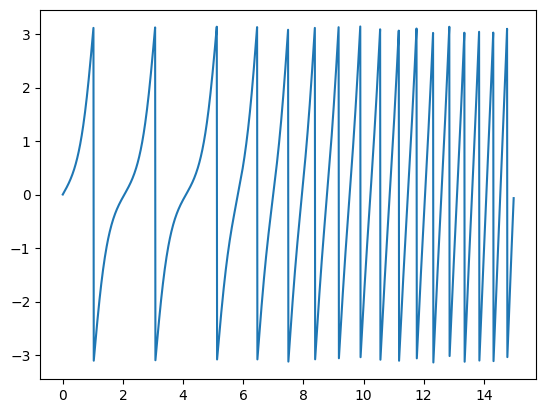

In [228]:
phases_sim = simulator.data['_x'][:,0]
angle_sim = np.arctan2(np.sin(phases_sim), np.cos(phases_sim))
plt.plot(simulator.data['_time'],angle_sim)


In [231]:
#Now let's try the same simulation using runge kutta
t_grid = simulator.data['_time']
G = 9.8
lam_const = 0

def tau(t):
    if t > 5:
        return 1
    else:
        return 0
    
def invert_pendulum(t,x):
    return np.array([x[1],G*np.sin(x[0]) - lam_const*x[1] + tau(t) ])

x0 = np.array([0,1])
solution_rk = inte.solve_ivp(invert_pendulum,(t_grid[0], t_grid[-1]) , x0, t_eval = t_grid.flatten(),rtol = 1e-10,atol = 1e-10)


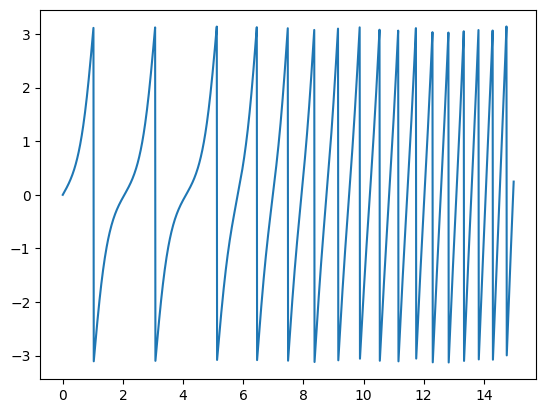

In [232]:
phases_rk = solution_rk.y[0,:]
angle_rk = np.arctan2(np.sin(phases_rk), np.cos(phases_rk))
plt.plot(solution_rk.t,angle_rk)

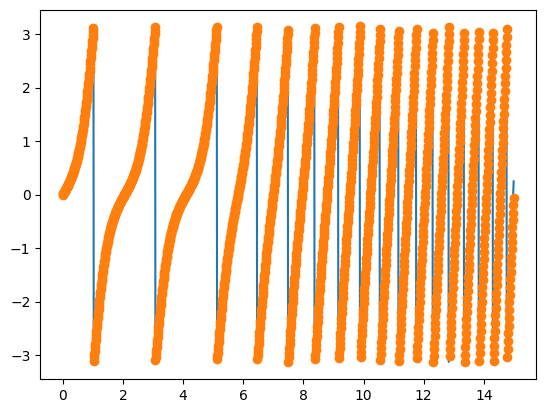

In [233]:
# Now comparing the error
plt.plot(simulator.data['_time'],angle_rk)
plt.plot(simulator.data['_time'],angle_sim,'o')



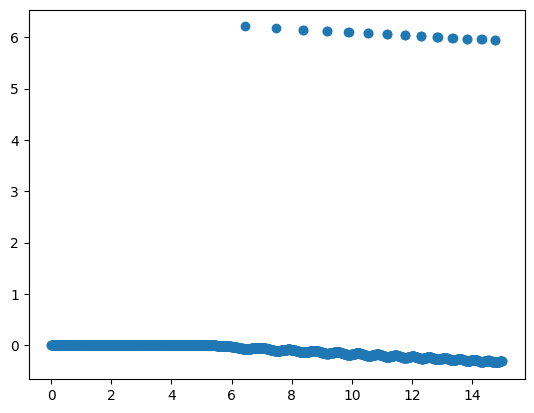

In [234]:
plt.plot(simulator.data['_time'],angle_sim-angle_rk,'o')
